In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl


### Get the data 

In [4]:
fashion_set = fashion_mnist.load_data()

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_set

9

In [136]:
def plot_image(X, y, images_per_row=10):
    size = 28 #default size X_train.shape
    number_img = X.shape[0]
    no_rows = int(np.ceil(number_img/images_per_row))
    n_empty_image = no_rows * images_per_row - number_img

    #combine input with empty set
    image_set = np.concatenate([X, np.zeros((n_empty_image, size, size))], axis=0)
    label_set = np.concatenate([y, -np.ones(n_empty_image)], axis=0)
    #image_grid = image_set.reshape(no_rows, images_per_row, size, size)
    #images = image_grid.transpose(0,2,1,3).reshape(no_rows * size, images_per_row * size)
    print(image_set.shape)
    #plt.imshow(X=images, , cmap=mpl.cm.binary)
    fig, axes = plt.subplots(nrows=no_rows, ncols=images_per_row, figsize=(images_per_row * 1.5,no_rows))
    fig.tight_layout(pad=0.13, rect=[0, 0.12, 1, 2]) #[left,bottom, right, top]
    
    for (i,ax), y_set in zip(enumerate(axes.flat), label_set):
        ax.imshow(image_set[i], cmap=mpl.cm.binary)
        ax.set_title(f'{y_set}')
        ax.set_xticks([])
        ax.set_yticks([])
    

(12, 28, 28)


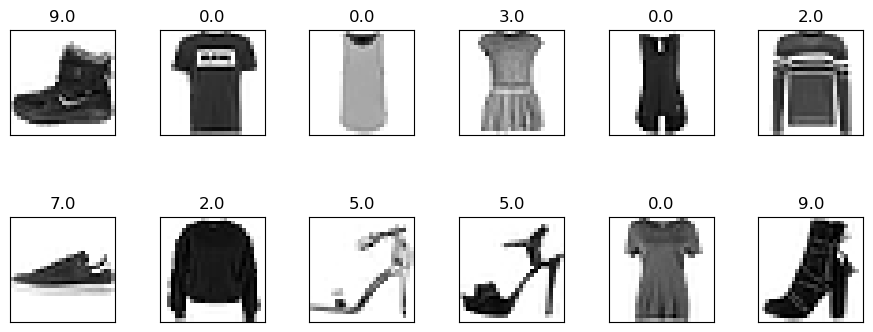

In [137]:
plot_image(X_train[:12], y_train[:12], images_per_row=6)

In [141]:
#Preprocess value before building model
X_train_process = X_train / 255

### import model

In [189]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [196]:
#input shape(28, 28)

model = Sequential([
    Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)),
    Conv2D(16, (3,3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='linear')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))

In [197]:
X_train_conv = np.expand_dims(X_train_process, axis=-1)
X_train_conv.shape


(60000, 28, 28, 1)

In [2]:
model = tf.keras.saving.load_model('model.pkl')

In [207]:
model.fit(X_train_conv, y_train.reshape(-1,1), verbose=2, epochs=20)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_11/conv2d_25/Relu' defined at (most recent call last):
    File "d:\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "d:\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "d:\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "d:\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "d:\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "d:\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "d:\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "d:\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "d:\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17524\337440981.py", line 1, in <module>
      model.fit(X_train_process, y_train.reshape(-1,1), verbose=2, epochs=20)
    File "d:\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "d:\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 321, in call
      return self.activation(outputs)
    File "d:\anaconda3\lib\site-packages\keras\src\activations.py", line 321, in relu
      return backend.relu(
    File "d:\anaconda3\lib\site-packages\keras\src\backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential_11/conv2d_25/Relu'
convolution input must be 4-dimensional: [32,28,28]
	 [[{{node sequential_11/conv2d_25/Relu}}]] [Op:__inference_train_function_195018]

In [199]:
model.save('model.pkl')

INFO:tensorflow:Assets written to: model.pkl\assets


INFO:tensorflow:Assets written to: model.pkl\assets


In [6]:
from sklearn.metrics import accuracy_score
X_test_process = X_test / 255
y_pred = model.predict(X_test)

accuracy_score(y_test, np.argmax(y_pred, axis=1))

313/313 [==============================] - 2s 6ms/step


0.8682